Dataset loaded successfully:
   CustomerID  Churn  Tenure PreferredLoginDevice  CityTier  WarehouseToHome  \
0       50001      1     4.0         Mobile Phone         3              6.0   
1       50002      1     NaN                Phone         1              8.0   
2       50003      1     NaN                Phone         1             30.0   
3       50004      1     0.0                Phone         3             15.0   
4       50005      1     0.0                Phone         1             12.0   

  PreferredPaymentMode  Gender  HourSpendOnApp  NumberOfDeviceRegistered  \
0           Debit Card  Female             3.0                         3   
1                  UPI    Male             3.0                         4   
2           Debit Card    Male             2.0                         4   
3           Debit Card    Male             2.0                         4   
4                   CC    Male             NaN                         3   

     PreferedOrderCat  Satisfacti

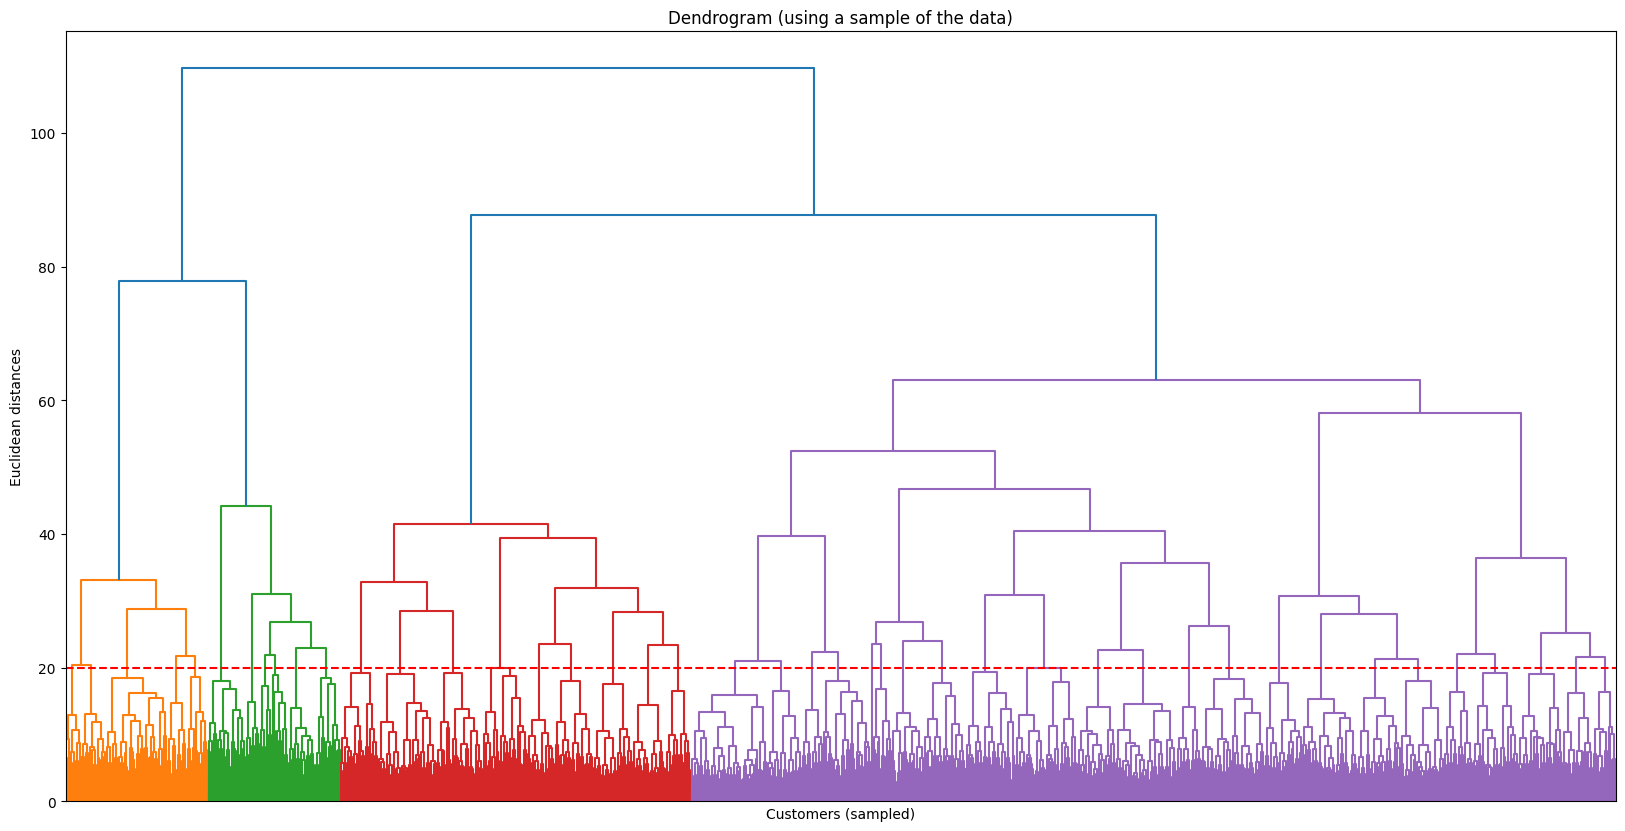


How to read the dendrogram:
1. Look for the longest vertical lines that do not cross any extended horizontal lines.
2. The number of vertical lines you can cut with a horizontal threshold gives the number of clusters.
3. Based on the dendrogram above, a good choice for the number of clusters seems to be between 3 and 5. Let's choose 4 for this analysis.

Performing Agglomerative Clustering with 4 clusters...
Clustering complete. Added 'Cluster' column to the original DataFrame.
   CustomerID  Churn  Tenure PreferredLoginDevice  CityTier  WarehouseToHome  \
0       50001      1     4.0         Mobile Phone         3              6.0   
1       50002      1     NaN                Phone         1              8.0   
2       50003      1     NaN                Phone         1             30.0   
3       50004      1     0.0                Phone         3             15.0   
4       50005      1     0.0                Phone         1             12.0   

  PreferredPaymentMode  Gender  Hou

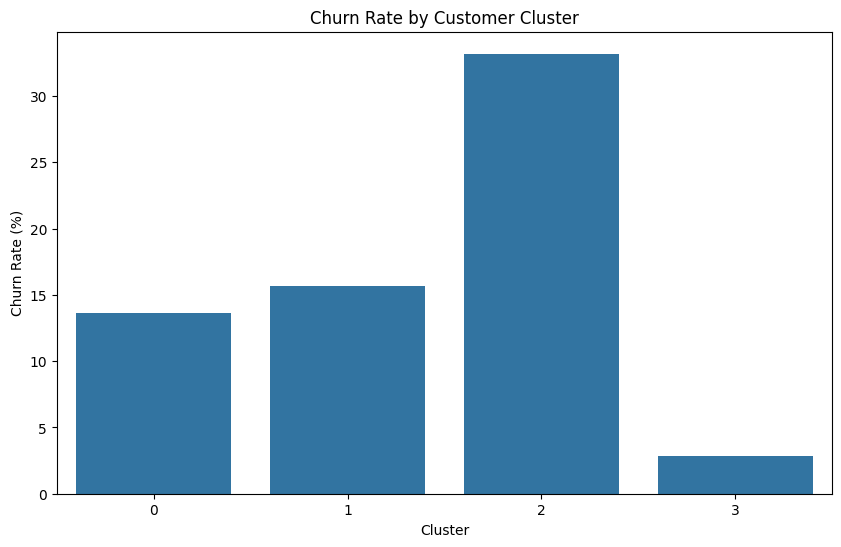

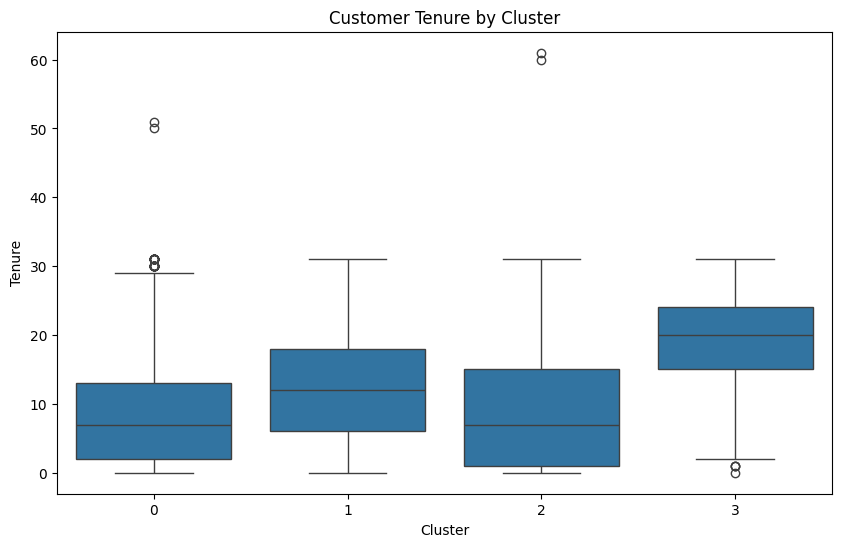

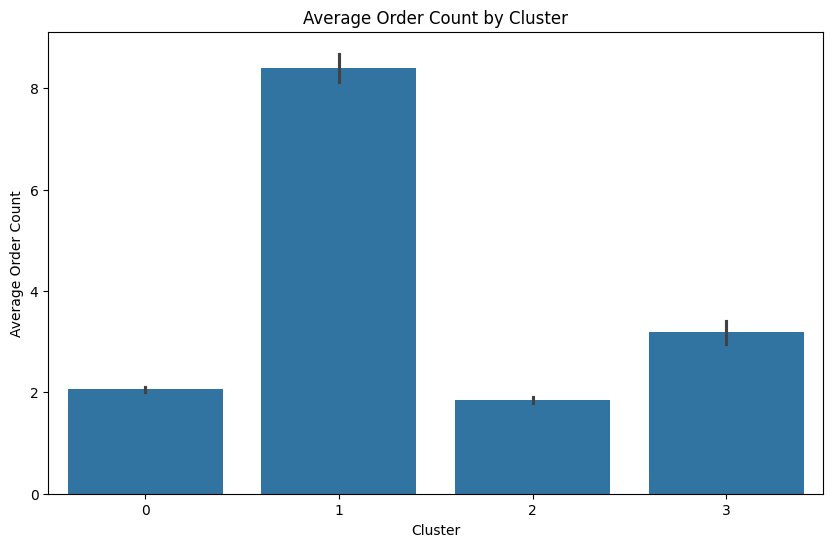

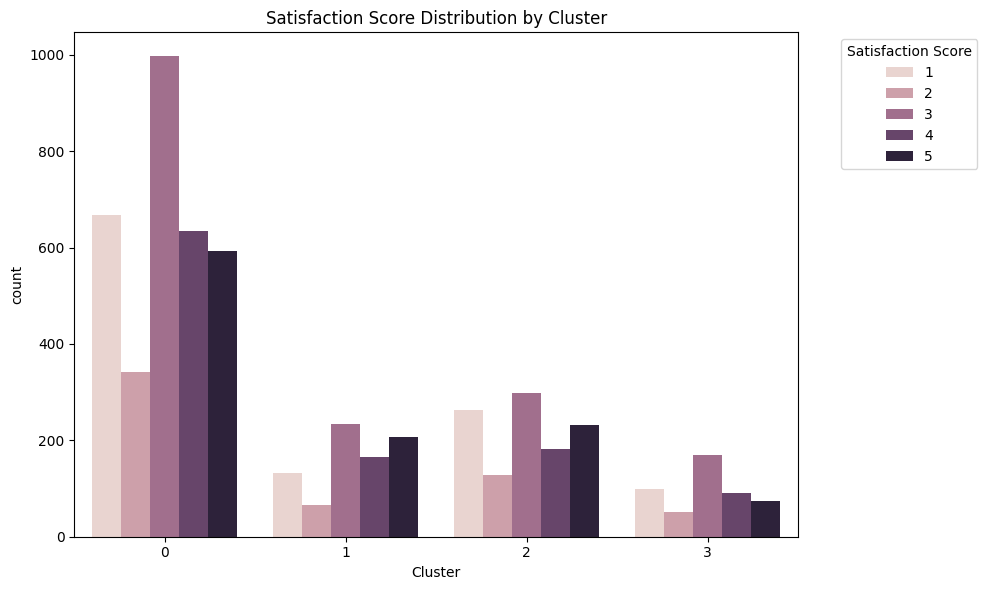

In [3]:
# Cell 1: Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as sch

# Cell 2: Load the dataset
# Make sure to replace 'ECommerce_Churn_Data.csv' with the actual path/name of your dataset file if it's different.
try:
    df = pd.read_csv('ECommerce_Churn_Data.csv')
except FileNotFoundError:
    print("Error: The dataset file 'ECommerce_Churn_Data.csv' was not found.")
    print("Please download the dataset from https://www.kaggle.com/datasets/ankitverma2010/ecommerce-customer-churn-analysis-and-prediction?resource=download")
    print("and place it in the correct directory or update the file path.")
    df = pd.DataFrame() # Create an empty DataFrame to avoid errors in subsequent cells

if not df.empty:
    print("Dataset loaded successfully:")
    print(df.head())

# Cell 3: Data Preprocessing for Clustering
if not df.empty:
    # Keep a copy of the original data for later analysis
    df_original = df.copy()

    # Drop CustomerID as it's just an identifier
    if 'CustomerID' in df.columns:
        df = df.drop('CustomerID', axis=1)
        print("\nDropped 'CustomerID' column.")

    # For clustering, we will not use the 'Churn' variable to create the clusters.
    # We will set it aside and use it later to analyze the resulting clusters.
    if 'Churn' in df.columns:
        features_df = df.drop('Churn', axis=1)
        print("Set aside the 'Churn' column for post-clustering analysis.")
    else:
        features_df = df
        print("Warning: 'Churn' column not found.")


    # Handle missing values (fill with mode for categorical and median for numerical)
    print("\nHandling missing values...")
    for column in features_df.select_dtypes(include=['object']).columns:
        features_df[column] = features_df[column].fillna(features_df[column].mode()[0])

    for column in features_df.select_dtypes(include=[np.number]).columns:
        features_df[column] = features_df[column].fillna(features_df[column].median())

    print("Missing values handled.")
    print("Shape of features DataFrame:", features_df.shape)

    # Identify categorical and numerical features for preprocessing
    categorical_features = features_df.select_dtypes(include=['object']).columns.tolist()
    numerical_features = features_df.select_dtypes(include=[np.number]).columns.tolist()

    print("\nCategorical Features:", categorical_features)
    print("Numerical Features:", numerical_features)

# Cell 4: Create and Apply Preprocessing Pipeline
if 'features_df' in locals():
    # Define preprocessing steps for numerical and categorical data
    numerical_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(handle_unknown='ignore', drop='first')

    # Create a preprocessor object using ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ],
        remainder='passthrough'
    )

    # Create a pipeline to apply the transformations
    preprocessing_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

    # Fit and transform the data
    print("\nApplying preprocessing (scaling and one-hot encoding)...")
    X_processed = preprocessing_pipeline.fit_transform(features_df)
    print("Preprocessing complete.")
    print("Shape of processed data:", X_processed.shape)
    
    # Note: Hierarchical clustering on very large datasets can be slow and memory-intensive.
    # If the dataset is too large, consider taking a sample.
    if X_processed.shape[0] > 5000:
        print("\nDataset is large. Taking a sample of 5000 points for dendrogram visualization to avoid performance issues.")
        # Note: The random state ensures reproducibility of the sample
        np.random.seed(42)
        sample_indices = np.random.choice(X_processed.shape[0], 5000, replace=False)
        X_sample = X_processed[sample_indices]
    else:
        X_sample = X_processed


# Cell 5: Visualize the Dendrogram to Determine Optimal Number of Clusters
if 'X_sample' in locals():
    print("\nGenerating dendrogram...")
    plt.figure(figsize=(20, 10))
    # 'ward' linkage minimizes the variance of the clusters being merged.
    dendrogram = sch.dendrogram(sch.linkage(X_sample, method='ward'))
    plt.title('Dendrogram (using a sample of the data)')
    plt.xlabel('Customers (sampled)')
    plt.ylabel('Euclidean distances')
    plt.xticks([]) # Hide x-axis labels for clarity
    plt.axhline(y=20, color='r', linestyle='--') # Example threshold line
    plt.show()
    
    print("\nHow to read the dendrogram:")
    print("1. Look for the longest vertical lines that do not cross any extended horizontal lines.")
    print("2. The number of vertical lines you can cut with a horizontal threshold gives the number of clusters.")
    print("3. Based on the dendrogram above, a good choice for the number of clusters seems to be between 3 and 5. Let's choose 4 for this analysis.")


# Cell 6: Perform Hierarchical Clustering and Assign Labels
if 'X_processed' in locals():
    # We choose 4 clusters based on the dendrogram analysis
    N_CLUSTERS = 4
    
    print(f"\nPerforming Agglomerative Clustering with {N_CLUSTERS} clusters...")
    
    # Initialize the model
    # metric='euclidean' and linkage='ward' are common and effective choices.
    # Note: 'affinity' was deprecated and replaced by 'metric' in recent scikit-learn versions.
    agg_cluster = AgglomerativeClustering(n_clusters=N_CLUSTERS, metric='euclidean', linkage='ward')

    # Fit the model and get cluster labels for the entire processed dataset
    cluster_labels = agg_cluster.fit_predict(X_processed)
    
    # Add the cluster labels back to the original, unprocessed DataFrame for analysis
    df_original['Cluster'] = cluster_labels
    print("Clustering complete. Added 'Cluster' column to the original DataFrame.")
    print(df_original.head())

# Cell 7: Analyze the Characteristics of Each Cluster
if 'df_original' in locals() and 'Cluster' in df_original.columns:
    print("\n--- Cluster Analysis ---")
    
    # Analyze churn rate per cluster
    churn_analysis = pd.crosstab(df_original['Cluster'], df_original['Churn'])
    churn_analysis['Churn_Rate'] = (churn_analysis[1] / (churn_analysis[0] + churn_analysis[1])) * 100
    print("\nChurn Rate per Cluster:")
    print(churn_analysis)

    # Analyze numerical features by cluster
    numerical_summary = df_original.groupby('Cluster')[numerical_features].mean().round(2)
    print("\nAverage of Numerical Features per Cluster:")
    print(numerical_summary)

    # Analyze categorical features by cluster
    print("\nMost Common Categorical Features per Cluster:")
    for feature in categorical_features:
        print(f"\n--- {feature} ---")
        print(df_original.groupby('Cluster')[feature].agg(lambda x: x.value_counts().index[0]))


# Cell 8: Visualize Cluster Differences
if 'df_original' in locals() and 'Cluster' in df_original.columns:
    print("\n--- Visualizing Cluster Characteristics ---")
    
    # Plot 1: Churn Rate per Cluster
    plt.figure(figsize=(10, 6))
    sns.barplot(x=churn_analysis.index, y=churn_analysis['Churn_Rate'])
    plt.title('Churn Rate by Customer Cluster')
    plt.ylabel('Churn Rate (%)')
    plt.show()

    # Plot 2: Tenure by Cluster
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Cluster', y='Tenure', data=df_original)
    plt.title('Customer Tenure by Cluster')
    plt.show()
    
    # Plot 3: Order Count by Cluster
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Cluster', y='OrderCount', data=df_original, estimator=np.mean)
    plt.title('Average Order Count by Cluster')
    plt.ylabel('Average Order Count')
    plt.show()

    # Plot 4: Satisfaction Score by Cluster
    plt.figure(figsize=(10, 6))
    sns.countplot(x='Cluster', hue='SatisfactionScore', data=df_original)
    plt.title('Satisfaction Score Distribution by Cluster')
    plt.legend(title='Satisfaction Score', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()